# Median ligand generation based on SELFIE interpolation
### STONED imports & definitions

In [1]:
import time 
import selfies
import rdkit
import random
import numpy as np
import random
from rdkit import Chem
from selfies import encoder, decoder
from rdkit.Chem import MolFromSmiles as smi2mol
from rdkit.Chem import AllChem
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity
from rdkit.Chem import Mol
from rdkit.Chem.AtomPairs.Sheridan import GetBPFingerprint, GetBTFingerprint
from rdkit.Chem.Pharm2D import Generate, Gobbi_Pharm2D
from rdkit.Chem import Draw

from rdkit.Chem import MolToSmiles as mol2smi
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

def randomize_smiles(mol):
    '''Returns a random (dearomatized) SMILES given an rdkit mol object of a molecule.
    Parameters:
    mol (rdkit.Chem.rdchem.Mol) :  RdKit mol object (None if invalid smile string smi)
    
    Returns:
    mol (rdkit.Chem.rdchem.Mol) : RdKit mol object  (None if invalid smile string smi)
    '''
    if not mol:
        return None

    Chem.Kekulize(mol)
    return rdkit.Chem.MolToSmiles(mol, canonical=False, doRandom=True, isomericSmiles=False,  kekuleSmiles=True) 


def sanitize_smiles(smi):
    '''Return a canonical smile representation of smi
    
    Parameters:
    smi (string) : smile string to be canonicalized 
    
    Returns:
    mol (rdkit.Chem.rdchem.Mol) : RdKit mol object                          (None if invalid smile string smi)
    smi_canon (string)          : Canonicalized smile representation of smi (None if invalid smile string smi)
    conversion_successful (bool): True/False to indicate if conversion was  successful 
    '''
    try:
        mol = smi2mol(smi, sanitize=True)
        smi_canon = mol2smi(mol, isomericSmiles=False, canonical=True)
        return (mol, smi_canon, True)
    except:
        return (None, None, False)
    

def get_selfie_chars(selfie):
    '''Obtain a list of all selfie characters in string selfie
    
    Parameters: 
    selfie (string) : A selfie string - representing a molecule 
    
    Example: 
    >>> get_selfie_chars('[C][=C][C][=C][C][=C][Ring1][Branch1_1]')
    ['[C]', '[=C]', '[C]', '[=C]', '[C]', '[=C]', '[Ring1]', '[Branch1_1]']
    
    Returns:
    chars_selfie: list of selfie characters present in molecule selfie
    '''
    chars_selfie = [] # A list of all SELFIE sybols from string selfie
    while selfie != '':
        chars_selfie.append(selfie[selfie.find('['): selfie.find(']')+1])
        selfie = selfie[selfie.find(']')+1:]
    return chars_selfie


class _FingerprintCalculator:
    ''' Calculate the fingerprint for a molecule, given the fingerprint type
    Parameters: 
        mol (rdkit.Chem.rdchem.Mol) : RdKit mol object (None if invalid smile string smi)
        fp_type (string)            :Fingerprint type  (choices: AP/PHCO/BPF,BTF,PAT,ECFP4,ECFP6,FCFP4,FCFP6)  
    Returns:
        RDKit fingerprint object
    '''

    def get_fingerprint(self, mol: Mol, fp_type: str):
        method_name = 'get_' + fp_type
        method = getattr(self, method_name)
        if method is None:
            raise Exception(f'{fp_type} is not a supported fingerprint type.')
        return method(mol)

    def get_AP(self, mol: Mol):
        return AllChem.GetAtomPairFingerprint(mol, maxLength=10)

    def get_PHCO(self, mol: Mol):
        return Generate.Gen2DFingerprint(mol, Gobbi_Pharm2D.factory)

    def get_BPF(self, mol: Mol):
        return GetBPFingerprint(mol)

    def get_BTF(self, mol: Mol):
        return GetBTFingerprint(mol)

    def get_PATH(self, mol: Mol):
        return AllChem.RDKFingerprint(mol)

    def get_ECFP4(self, mol: Mol):
        return AllChem.GetMorganFingerprint(mol, 2)

    def get_ECFP6(self, mol: Mol):
        return AllChem.GetMorganFingerprint(mol, 3)

    def get_FCFP4(self, mol: Mol):
        return AllChem.GetMorganFingerprint(mol, 2, useFeatures=True)

    def get_FCFP6(self, mol: Mol):
        return AllChem.GetMorganFingerprint(mol, 3, useFeatures=True)


def get_fingerprint(mol: Mol, fp_type: str):
    ''' Fingerprint getter method. Fingerprint is returned after using object of 
        class '_FingerprintCalculator'
        
    Parameters: 
        mol (rdkit.Chem.rdchem.Mol) : RdKit mol object (None if invalid smile string smi)
        fp_type (string)            :Fingerprint type  (choices: AP/PHCO/BPF,BTF,PAT,ECFP4,ECFP6,FCFP4,FCFP6)  
    Returns:
        RDKit fingerprint object
        
    '''
    return _FingerprintCalculator().get_fingerprint(mol=mol, fp_type=fp_type)

def mutate_selfie(selfie, max_molecules_len, write_fail_cases=False):
    '''Return a mutated selfie string (only one mutation on slefie is performed)
    
    Mutations are done until a valid molecule is obtained 
    Rules of mutation: With a 33.3% propbabily, either: 
        1. Add a random SELFIE character in the string
        2. Replace a random SELFIE character with another
        3. Delete a random character
    
    Parameters:
    selfie            (string)  : SELFIE string to be mutated 
    max_molecules_len (int)     : Mutations of SELFIE string are allowed up to this length
    write_fail_cases  (bool)    : If true, failed mutations are recorded in "selfie_failure_cases.txt"
    
    Returns:
    selfie_mutated    (string)  : Mutated SELFIE string
    smiles_canon      (string)  : canonical smile of mutated SELFIE string
    '''
    valid=False
    fail_counter = 0
    chars_selfie = get_selfie_chars(selfie)
    
    while not valid:
        fail_counter += 1
                
        alphabet = list(selfies.get_semantic_robust_alphabet()) # 34 SELFIE characters 

        choice_ls = [1, 2, 3] # 1=Insert; 2=Replace; 3=Delete
        random_choice = np.random.choice(choice_ls, 1)[0]
        
        # Insert a character in a Random Location
        if random_choice == 1: 
            random_index = np.random.randint(len(chars_selfie)+1)
            random_character = np.random.choice(alphabet, size=1)[0]
            
            selfie_mutated_chars = chars_selfie[:random_index] + [random_character] + chars_selfie[random_index:]

        # Replace a random character 
        elif random_choice == 2:                         
            random_index = np.random.randint(len(chars_selfie))
            random_character = np.random.choice(alphabet, size=1)[0]
            if random_index == 0:
                selfie_mutated_chars = [random_character] + chars_selfie[random_index+1:]
            else:
                selfie_mutated_chars = chars_selfie[:random_index] + [random_character] + chars_selfie[random_index+1:]
                
        # Delete a random character
        elif random_choice == 3: 
            random_index = np.random.randint(len(chars_selfie))
            if random_index == 0:
                selfie_mutated_chars = chars_selfie[random_index+1:]
            else:
                selfie_mutated_chars = chars_selfie[:random_index] + chars_selfie[random_index+1:]
                
        else: 
            raise Exception('Invalid Operation trying to be performed')

        selfie_mutated = "".join(x for x in selfie_mutated_chars)
        sf = "".join(x for x in chars_selfie)
        
        try:
            smiles = decoder(selfie_mutated)
            mol, smiles_canon, done = sanitize_smiles(smiles)
            if len(selfie_mutated_chars) > max_molecules_len or smiles_canon=="":
                done = False
            if done:
                valid = True
            else:
                valid = False
        except:
            valid=False
            if fail_counter > 1 and write_fail_cases == True:
                f = open("selfie_failure_cases.txt", "a+")
                f.write('Tried to mutate SELFIE: '+str(sf)+' To Obtain: '+str(selfie_mutated) + '\n')
                f.close()
    
    return (selfie_mutated, smiles_canon)

def get_mutated_SELFIES(selfies_ls, num_mutations): 
    ''' Mutate all the SELFIES in 'selfies_ls' 'num_mutations' number of times. 
    
    Parameters:
    selfies_ls   (list)  : A list of SELFIES 
    num_mutations (int)  : number of mutations to perform on each SELFIES within 'selfies_ls'
    
    Returns:
    selfies_ls   (list)  : A list of mutated SELFIES
    
    '''
    for _ in range(num_mutations): 
        selfie_ls_mut_ls = []
        for str_ in selfies_ls: 
            
            str_chars = get_selfie_chars(str_)
            max_molecules_len = len(str_chars) + num_mutations
            
            selfie_mutated, _ = mutate_selfie(str_, max_molecules_len)
            selfie_ls_mut_ls.append(selfie_mutated)
        
        selfies_ls = selfie_ls_mut_ls.copy()
    return selfies_ls


def get_fp_scores(smiles_back, target_smi, fp_type): 
    '''Calculate the Tanimoto fingerprint (using fp_type fingerint) similarity between a list 
       of SMILES and a known target structure (target_smi). 
       
    Parameters:
    smiles_back   (list) : A list of valid SMILES strings 
    target_smi (string)  : A valid SMILES string. Each smile in 'smiles_back' will be compared to this stucture
    fp_type (string)     : Type of fingerprint  (choices: AP/PHCO/BPF,BTF,PAT,ECFP4,ECFP6,FCFP4,FCFP6) 
    
    Returns: 
    smiles_back_scores (list of floats) : List of fingerprint similarities
    '''
    smiles_back_scores = []
    target    = Chem.MolFromSmiles(target_smi)

    fp_target = get_fingerprint(target, fp_type)

    for item in smiles_back: 
        mol    = Chem.MolFromSmiles(item)
        fp_mol = get_fingerprint(mol, fp_type)
        score  = TanimotoSimilarity(fp_mol, fp_target)
        smiles_back_scores.append(score)
    return smiles_back_scores


In [2]:
import os
import numpy as np 
import random
from random import randrange
import matplotlib.pyplot as plt
import rdkit
from rdkit.Chem import MolFromSmiles as smi2mol
from rdkit.Chem import MolToSmiles as mol2smi
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity
from selfies import encoder, decoder 


import seaborn as sns
import selfies
import random
import numpy as np
from selfies import encoder, decoder

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

def get_ECFP4(mol):
    ''' Return rdkit ECFP4 fingerprint object for mol

    Parameters: 
    mol (rdkit.Chem.rdchem.Mol) : RdKit mol object  

    Returns: 
    rdkit ECFP4 fingerprint object for mol
    '''
    return AllChem.GetMorganFingerprint(mol, 2)

def sanitize_smiles(smi):
    '''Return a canonical smile representation of smi
    
    Parameters:
    smi (string) : smile string to be canonicalized 
    
    Returns:
    mol (rdkit.Chem.rdchem.Mol) : RdKit mol object                          (None if invalid smile string smi)
    smi_canon (string)          : Canonicalized smile representation of smi (None if invalid smile string smi)
    conversion_successful (bool): True/False to indicate if conversion was  successful 
    '''
    try:
        mol = smi2mol(smi, sanitize=True)
        smi_canon = mol2smi(mol, isomericSmiles=False, canonical=True)
        return (mol, smi_canon, True)
    except:
        return (None, None, False)

def get_fp_scores(smiles_back, target_smi): 
    '''Calculate the Tanimoto fingerprint (ECFP4 fingerint) similarity between a list 
       of SMILES and a known target structure (target_smi). 
       
    Parameters:
    smiles_back   (list) : A list of valid SMILES strings 
    target_smi (string)  : A valid SMILES string. Each smile in 'smiles_back' will be compared to this stucture
    
    Returns: 
    smiles_back_scores (list of floats) : List of fingerprint similarities
    '''
    smiles_back_scores = []
    target    = Chem.MolFromSmiles(target_smi)
    fp_target = get_ECFP4(target)
    for item in smiles_back: 
        mol    = Chem.MolFromSmiles(item)
        fp_mol = get_ECFP4(mol)
        score  = TanimotoSimilarity(fp_mol, fp_target)
        smiles_back_scores.append(score)
    return smiles_back_scores


def get_selfie_chars(selfie):
    '''Obtain a list of all selfie characters in string selfie
    
    Parameters: 
    selfie (string) : A selfie string - representing a molecule 
    
    Example: 
    >>> get_selfie_chars('[C][=C][C][=C][C][=C][Ring1][Branch1_1]')
    ['[C]', '[=C]', '[C]', '[=C]', '[C]', '[=C]', '[Ring1]', '[Branch1_1]']
    
    Returns:
    chars_selfie: list of selfie characters present in molecule selfie
    '''
    chars_selfie = [] # A list of all SELFIE sybols from string selfie
    while selfie != '':
        chars_selfie.append(selfie[selfie.find('['): selfie.find(']')+1])
        selfie = selfie[selfie.find(']')+1:]
    return chars_selfie


def randomize_smiles(mol):
    '''Returns a random (dearomatized) SMILES given an rdkit mol object of a molecule.

    Parameters:
    mol (rdkit.Chem.rdchem.Mol) :  RdKit mol object (None if invalid smile string smi)
    
    Returns:
    mol (rdkit.Chem.rdchem.Mol) : RdKit mol object  (None if invalid smile string smi)
    '''
    if not mol:
        return None

    Chem.Kekulize(mol)
    
    return rdkit.Chem.MolToSmiles(mol, canonical=False, doRandom=True, isomericSmiles=False,  kekuleSmiles=True)


def get_random_smiles(smi, num_random_samples): 
    ''' Obtain 'num_random_samples' non-unique SMILES orderings of smi
    
    Parameters:
    smi (string)            : Input SMILES string (needs to be a valid molecule)
    num_random_samples (int): Number fo unique different SMILES orderings to form 
    
    Returns:
    randomized_smile_orderings (list) : list of SMILES strings
    '''
    mol = Chem.MolFromSmiles(smi)
    if mol == None: 
        raise Exception('Invalid starting structure encountered')
    randomized_smile_orderings  = [randomize_smiles(mol) for _ in range(num_random_samples)]
    randomized_smile_orderings  = list(set(randomized_smile_orderings)) # Only consider unique SMILE strings
    return randomized_smile_orderings


def obtain_path(starting_smile, target_smile, filter_path=False): 
    ''' Obtain a path/chemical path from starting_smile to target_smile
    
    Parameters:
    starting_smile (string) : SMILES string (needs to be a valid molecule)
    target_smile (int)      : SMILES string (needs to be a valid molecule)
    filter_path (bool)      : If True, a chemical path is returned, else only a path
    
    Returns:
    path_smiles (list)                  : A list of smiles in path between starting_smile & target_smile
    path_fp_scores (list of floats)     : Fingerprint similarity to 'target_smile' for each smiles in path_smiles
    smiles_path (list)                  : A list of smiles in CHEMICAL path between starting_smile & target_smile (if filter_path==False, then empty)
    filtered_path_score (list of floats): Fingerprint similarity to 'target_smile' for each smiles in smiles_path (if filter_path==False, then empty)
    '''
    starting_selfie = encoder(starting_smile)
    target_selfie   = encoder(target_smile)
    
    starting_selfie_chars = get_selfie_chars(starting_selfie)
    target_selfie_chars   = get_selfie_chars(target_selfie)
    
    # Pad the smaller string
    if len(starting_selfie_chars) < len(target_selfie_chars): 
        for _ in range(len(target_selfie_chars)-len(starting_selfie_chars)):
            starting_selfie_chars.append(' ')
    else: 
        for _ in range(len(starting_selfie_chars)-len(target_selfie_chars)):
            target_selfie_chars.append(' ')
    
    indices_diff = [i for i in range(len(starting_selfie_chars)) if starting_selfie_chars[i] != target_selfie_chars[i]]
    path         = {}
    path[0]  = starting_selfie_chars
    
    for iter_ in range(len(indices_diff)): 
        idx = np.random.choice(indices_diff, 1)[0] # Index to be operated on
        indices_diff.remove(idx)                   # Remove that index
        
        # Select the last member of path: 
        path_member = path[iter_].copy()
        
        # Mutate that character to the correct value: 
        path_member[idx] = target_selfie_chars[idx]
        path[iter_+1] = path_member.copy()
    
    # Collapse path to make them into SELFIE strings
    paths_selfies = []
    for i in range(len(path)):
        selfie_str = ''.join(x for x in path[i])
        paths_selfies.append(selfie_str.replace(' ', ''))
        
    if paths_selfies[-1] != target_selfie: 
        raise Exception("Unable to discover target structure!")
    
    # Obtain similarity scores, and only choose the increasing members: 
    path_smiles         = [decoder(x) for x in paths_selfies]
    path_fp_scores      = []
    filtered_path_score = []
    smiles_path         = []
    
    if filter_path: 
        path_fp_scores = get_fp_scores(path_smiles, target_smile)
        
        filtered_path_score = []
        smiles_path   = []
        for i in range(1, len(path_fp_scores)-1): 
            if i == 1: 
                filtered_path_score.append(path_fp_scores[1])
                smiles_path.append(path_smiles[i])
                continue
            if filtered_path_score[-1] < path_fp_scores[i]:
                filtered_path_score.append(path_fp_scores[i])
                smiles_path.append(path_smiles[i])

    return path_smiles, path_fp_scores, smiles_path, filtered_path_score


def get_compr_paths(starting_smile, target_smile, num_tries, num_random_samples, collect_bidirectional):
    ''' Obtaining multiple paths/chemical paths from starting_smile to target_smile. 
    
    Parameters:
    starting_smile (string)     : SMILES string (needs to be a valid molecule)
    target_smile (int)          : SMILES string (needs to be a valid molecule)
    num_tries (int)             : Number of path/chemical path attempts between the exact same smiles
    num_random_samples (int)    : Number of different SMILES string orderings to conside for starting_smile & target_smile 
    collect_bidirectional (bool): If true, forms paths from target_smiles-> target_smiles (doubles number of paths)
    
    Returns:
    smiles_paths_dir1 (list): list paths containing smiles in path between starting_smile -> target_smile
    smiles_paths_dir2 (list): list paths containing smiles in path between target_smile -> starting_smile
    '''
    starting_smile_rand_ord = get_random_smiles(starting_smile, num_random_samples=num_random_samples)
    target_smile_rand_ord   = get_random_smiles(target_smile,   num_random_samples=num_random_samples)
    
    smiles_paths_dir1 = [] # All paths from starting_smile -> target_smile
    for smi_start in starting_smile_rand_ord: 
        for smi_target in target_smile_rand_ord: 
            
            if Chem.MolFromSmiles(smi_start) == None or Chem.MolFromSmiles(smi_target) == None: 
                raise Exception('Invalid structures')
                
            for _ in range(num_tries): 
                path, _, _, _ = obtain_path(smi_start, smi_target, filter_path=True)
                smiles_paths_dir1.append(path)
    
    smiles_paths_dir2 = [] # All paths from starting_smile -> target_smile
    if collect_bidirectional == True: 
        starting_smile_rand_ord = get_random_smiles(target_smile, num_random_samples=num_random_samples)
        target_smile_rand_ord   = get_random_smiles(starting_smile,   num_random_samples=num_random_samples)
        
        for smi_start in starting_smile_rand_ord: 
            for smi_target in target_smile_rand_ord: 
                
                if Chem.MolFromSmiles(smi_start) == None or Chem.MolFromSmiles(smi_target) == None: 
                    raise Exception('Invalid structures')
        
                for _ in range(num_tries): 
                    path, _, _, _ = obtain_path(smi_start, smi_target, filter_path=True)
                    smiles_paths_dir2.append(path)
                    
    return smiles_paths_dir1, smiles_paths_dir2




In [3]:
def get_ECFP4(mol):
    return AllChem.GetMorganFingerprint(mol, 2)

def get_fp_scores(smiles_back, target_smi): 
    smiles_back_scores = []
    target    = Chem.MolFromSmiles(target_smi)
    fp_target = get_ECFP4(target)
    for item in smiles_back: 
        mol    = Chem.MolFromSmiles(item)
        fp_mol = get_ECFP4(mol)
        score  = TanimotoSimilarity(fp_mol, fp_target)
        smiles_back_scores.append(score)
    return smiles_back_scores



def sanitize_smiles(smi):
    try:
        mol = smi2mol(smi, sanitize=True)
        smi_canon = mol2smi(mol, isomericSmiles=False, canonical=True)
        return (mol, smi_canon, True)
    except:
        return (None, None, False)
    

def get_median_mols(starting_smile, target_smile, num_tries, num_random_samples, collect_bidirectional, num_top_iter): 
    
    smiles_paths_dir1, smiles_paths_dir2 = get_compr_paths(starting_smile, target_smile, num_tries, num_random_samples, collect_bidirectional)
    
    # Find the median molecule & plot: 
    all_smiles_dir_1 = [item for sublist in smiles_paths_dir1 for item in sublist] # all the smile string of dir1
    all_smiles_dir_2 = [item for sublist in smiles_paths_dir2 for item in sublist] # all the smile string of dir2
    
    all_smiles = [] # Collection of valid smile strings 
    for smi in all_smiles_dir_1 + all_smiles_dir_2: 
        if Chem.MolFromSmiles(smi) != None: 
            mol, smi_canon, _ = sanitize_smiles(smi)
            all_smiles.append(smi_canon)

    all_smiles = list(set(all_smiles))

    scores_start  = get_fp_scores(all_smiles, starting_smile)   # similarity to target
    scores_target = get_fp_scores(all_smiles, target_smile)     # similarity to starting structure
    data          = np.array([scores_target, scores_start])
    avg_score     = np.average(data, axis=0)
    better_score  = avg_score - (np.abs(data[0] - data[1]))   
    better_score  = ((1/9) * better_score**3) - ((7/9) * better_score**2) + ((19/12) * better_score)
    
    best_idx = better_score.argsort()[-num_top_iter:][::-1]
    best_smi = [all_smiles[i] for i in best_idx]
    best_scores = [better_score[i] for i in best_idx]

    return best_smi, best_scores    

# Generator tests


Notes:
- There is some model sensitivity even with these default settings
- num_tries and num_random_samples can be tweaked to balance quality and computing time
- some weird structures are generated *sometimes*
- overall good R-group responsiveness
- ~10 sec runtime per pert
- in some cases intermediates are very good, even positive charge gets pushed towards correct spot
- may be worth seeing if the MCS can be forced. Potentially even better to do per-R-group median generation and subsequent grafting
- Below examples involve a lot of cycle formation which may be out of scope for the work
- there is no difference in cost when asking for 1 or > 10 medians, so a clever picking algorithm is very applicable
- These are exceedingly difficult transformations, more 'normal' perts will likely work better.

In [138]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    from rdkit import Chem as _Chem
    from rdkit.Chem import rdFMCS as _rdFMCS
    from rdkit import RDLogger as _RDLogger

    # Disable RDKit warnings.
    _RDLogger.DisableLog('rdApp.*')
from rdkit.Chem import AllChem as _AllChem
from rdkit.Chem import Draw as _Draw
from rdkit.Chem import rdmolops as _rdmolops

from IPython.display import display
from itertools import chain

In [84]:
# settings.
num_tries             = 6
num_random_samples    = 6
collect_bidirectional = False # Doubles the number of paths: source->target & target->source
apply_filter          = False
num_top_iter          = 4    # Number of molecules that are selected after each iteration

In [142]:
def getMedian(lig_1_path, lig_2_path):
    
    # get eg5 ligands.
    lig_1 = Chem.SDMolSupplier(lig_1_path)[0]
    smi_1 = Chem.MolToSmiles(lig_1).replace("@", "")
    lig_1 = Chem.MolFromSmiles(smi_1) # bit silly but removes wedge bonds from final depictions.

    lig_2 = Chem.SDMolSupplier(lig_2_path)[0]
    smi_2 = Chem.MolToSmiles(lig_2).replace("@", "")
    lig_2 = Chem.MolFromSmiles(smi_2) # bit silly but removes wedge bonds from final depictions.

    # get medians between lambdas.
    smiles_, best_scores = get_median_mols(smi_1, smi_2, num_tries, num_random_samples, collect_bidirectional, num_top_iter)

    median_mols = [Chem.MolFromSmiles(x) for x in smiles_]

    triplets = []
    for mol_ in median_mols:
        # generate triplet of molecules where [lambda0, median, lambda1] and aligned.
        triplet = [lig_1, mol_, lig_2]

        # get the MCS.
        rdmols = [_Chem.RemoveHs(mol) for mol in triplet]

        template = _Chem.MolFromSmarts(_rdFMCS.FindMCS(triplet,
                        atomCompare=_rdFMCS.AtomCompare.CompareAny,
                        bondCompare=_rdFMCS.BondCompare.CompareAny,
                        matchValences=False,
                        ringMatchesRingOnly=True,
                        completeRingsOnly=True,
                        matchChiralTag=False).smartsString)
        _AllChem.Compute2DCoords(template)
        
        # align all ligands to the MCS. 
        for mol in rdmols:
            mol.UpdatePropertyCache(strict=False)
            _AllChem.Compute2DCoords(mol)
            _AllChem.GenerateDepictionMatching2DStructure(mol, template)

            mol = _Chem.RemoveHs(mol)

            # Remove stereochemistry to simplify depiction.
            _rdmolops.RemoveStereochemistry(mol)
        triplets.append(rdmols)
    return triplets

lambda 0:                                   Median:                                 lambda 1:


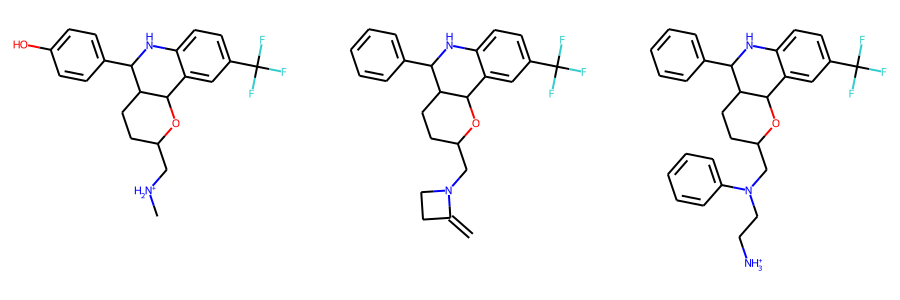

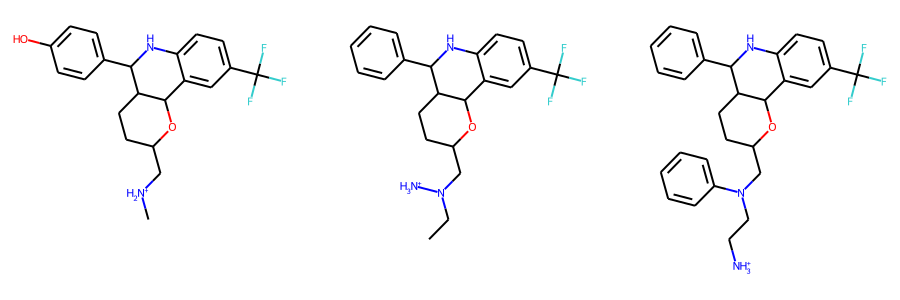

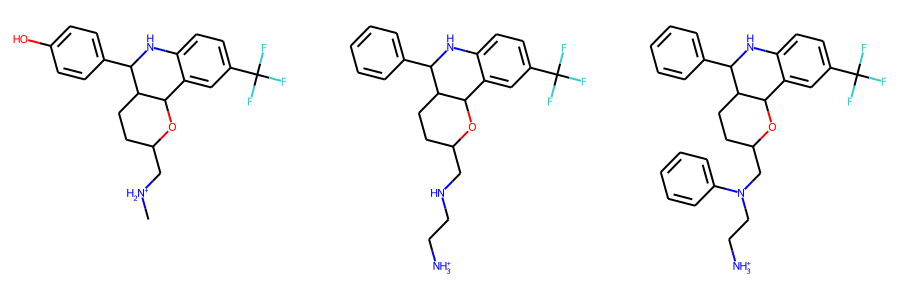

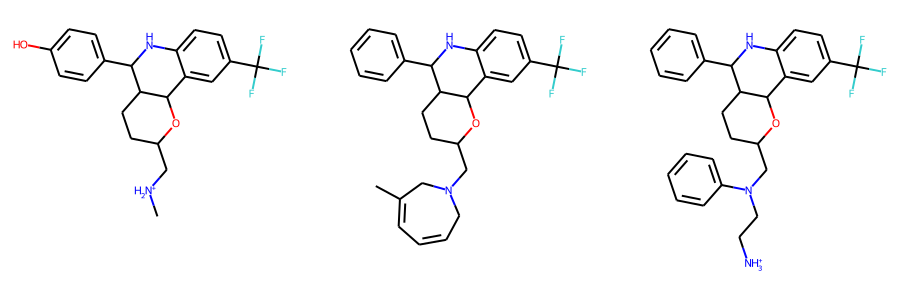

In [148]:
triplets_bucket = getMedian("ligands/EG5_07.sdf", "ligands/EG5_12.sdf")
print("lambda 0:                                   Median:                                 lambda 1:")
for triplet in triplets_bucket:
    img=Draw.MolsToGridImage(triplet,
                         molsPerRow=3, subImgSize=(300,300))
    display(img)

lambda 0:                                   Median:                                 lambda 1:


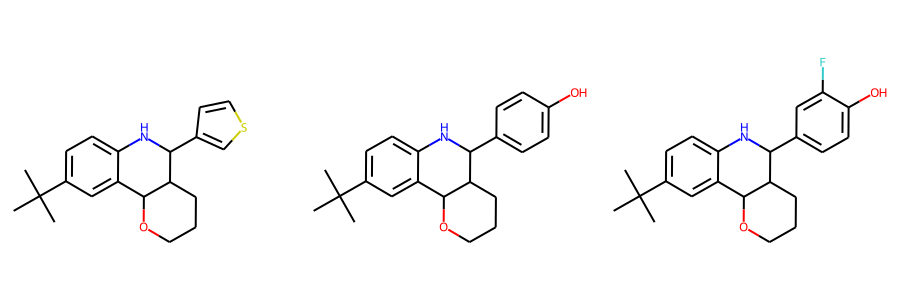

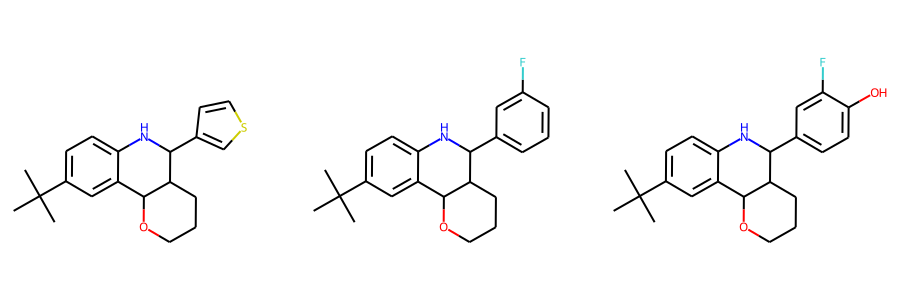

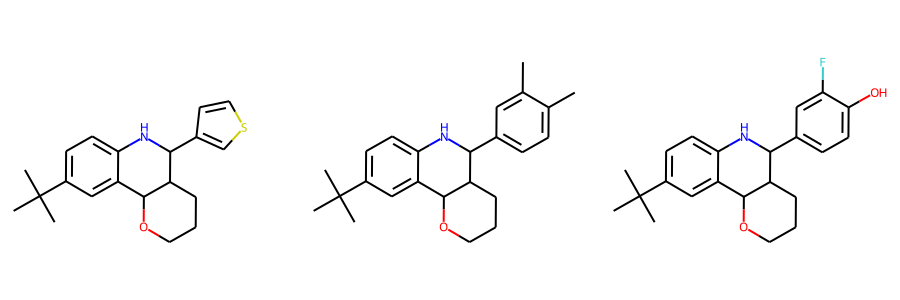

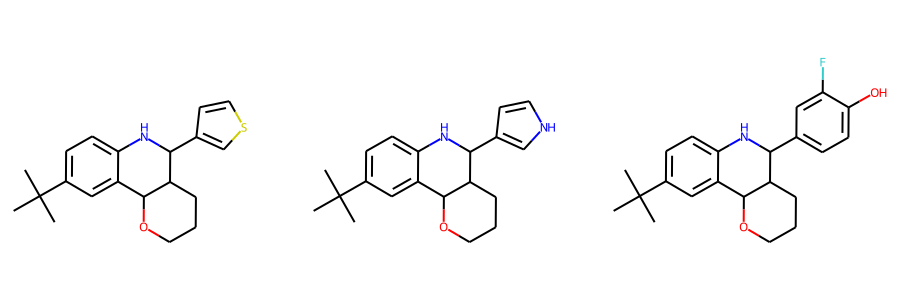

In [149]:
triplets_bucket = getMedian("ligands/EG5_28.sdf", "ligands/EG5_01.sdf")
print("lambda 0:                                   Median:                                 lambda 1:")
for triplet in triplets_bucket:
    img=Draw.MolsToGridImage(triplet,
                         molsPerRow=3, subImgSize=(300,300))
    display(img)

lambda 0:                                   Median:                                 lambda 1:


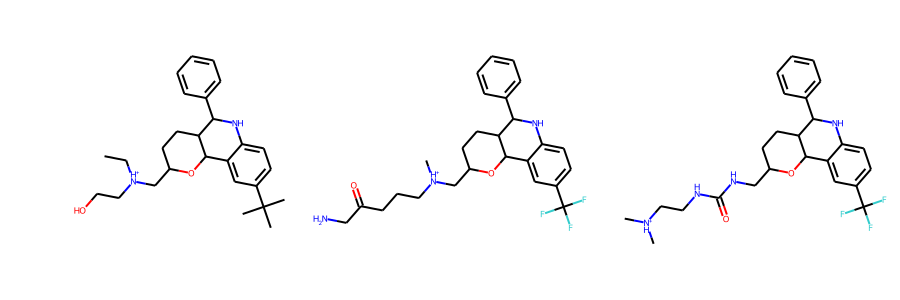

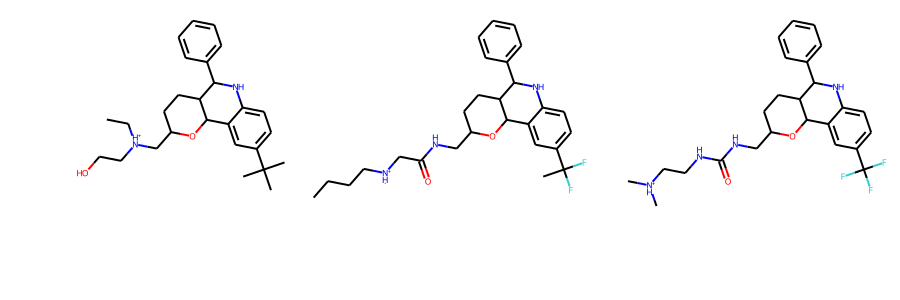

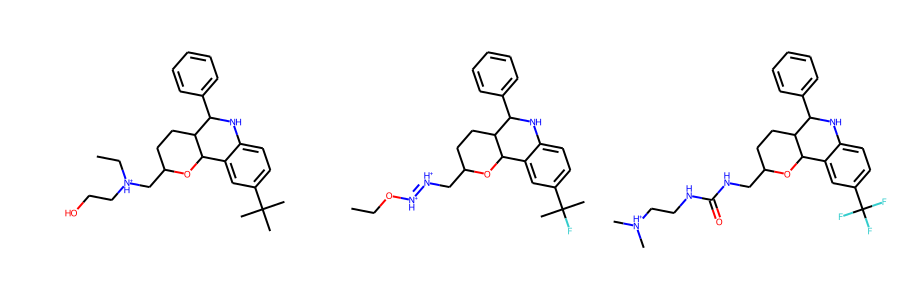

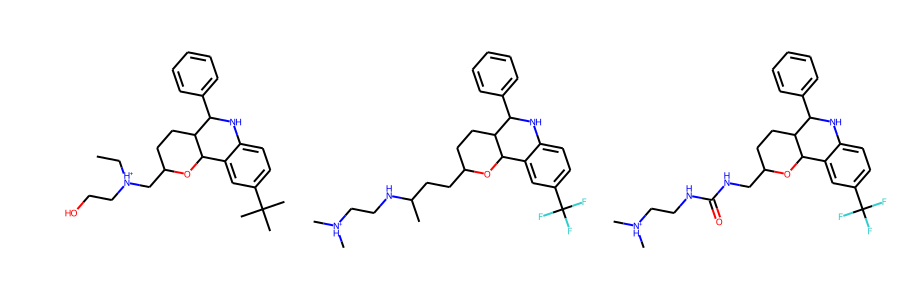

In [150]:
triplets_bucket = getMedian("ligands/EG5_19.sdf", "ligands/EG5_09.sdf")
print("lambda 0:                                   Median:                                 lambda 1:")
for triplet in triplets_bucket:
    img=Draw.MolsToGridImage(triplet,
                         molsPerRow=3, subImgSize=(300,300))
    display(img)

lambda 0:                                   Median:                                 lambda 1:


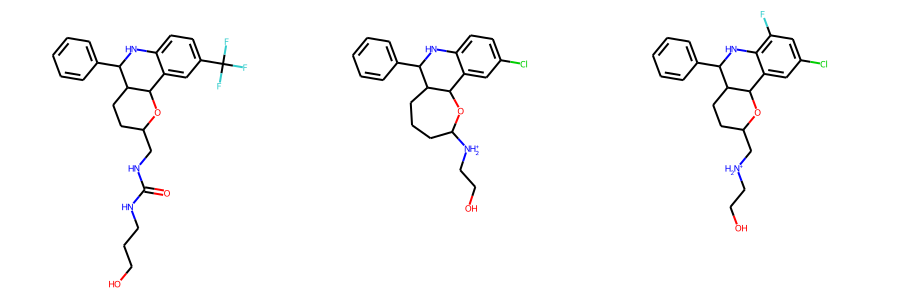

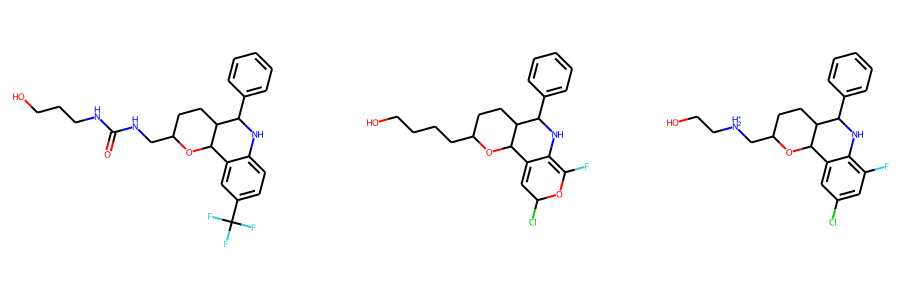

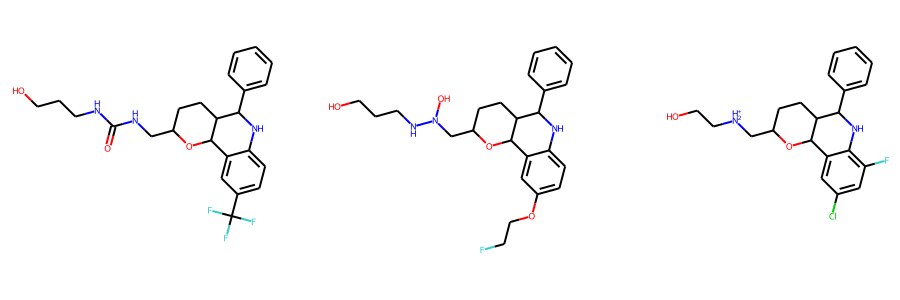

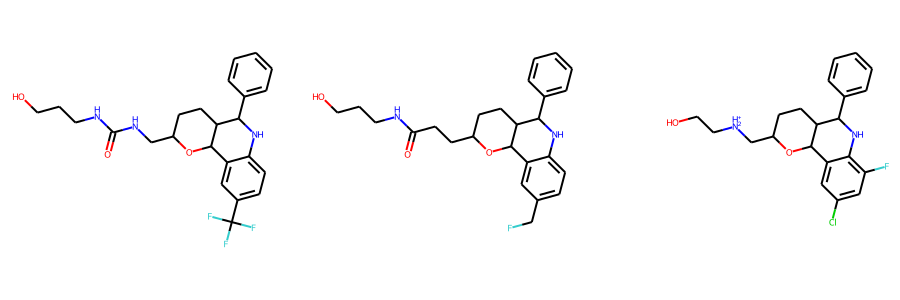

In [151]:
triplets_bucket = getMedian("ligands/EG5_03.sdf", "ligands/EG5_15.sdf")
print("lambda 0:                                   Median:                                 lambda 1:")
for triplet in triplets_bucket:
    img=Draw.MolsToGridImage(triplet,
                         molsPerRow=3, subImgSize=(300,300))
    display(img)